In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game


/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Identifying villager voting behavior patterns and stats

This notebook details the code used to look for certain identifiers in the voting patterns of villagers

## Behavioral Indicators and Stats

Other than training stats, possible in-game statistics may indicate different behavior and voting patterns amongst the agents

We want to 
 - Look at unique votes from villagers throughout accusation and voting. Do these go down?
    - Is there a difference between wins/losses?

 - When are wolves voted out? Earlier or later?
    - If so, when is the second wolf found? How many voting rounds after the first wolf killed



Here are some things we might care about finding out:
- [ ] How many execution votes led to ties? 
    - Did these favor the wolves or the villagers?
- [ ] Villagers who have the same votes as others between accusations (is there accord between villagers)
- [ ] What id's do wolves have in games with villager wins
- [ ] How many distinct votes do we have? (per accusation round, per voting round)


Some stuff might be specific to approval, plurality or ranked voting
Approval 
- [ ] How many villagers vote the exact same way (with approvals and neutrals )
- [ ] How many negative votes do villagers give on average. Does this change with training ? *Stat to track while training


In terms of gathering up the stats, does it make more sense to look at the history, or does it make sense to just gather them while we train? it might be better to do it post game?

Lets look at unique votes accusation -> voting
How many unique votes are there from accusation to voting?
If they switch, does a bigger count switch down to a little one? or does a smaller count lose a number to the bigger one?

Did a villager switch to a werewolf vote?
wolf to wolf?

What proportion of votes are for werewolves?

How often is the vote against a dead player?

- [ ] In situations where we have a wolf who died, do players still vote against them?

- [ ] Do we have 3 way ties between both werewolves and the werewolf target?
        Is it possible that we actually lose because there is less consensus between agents on who they want to target?

do villagers win more given a first wolf vote?
is there a vote they key on quicker?

On voting rounds:
    - [ ] Does a wolf get lucky, and agents split their votes between the wolves, and the wolf target actually gets killed?

General game questions:
    - Does the first target a wolf pick impact their chance of winning? Alternatively, do villagers key better on certain first wolf votes?
    - Do certain wolf id combinations lead to more villager wins? 

## Static Wolf Policies

In [2]:
def random_plurality_wolf(env, agent, action=None):
    villagers_remaining = set(env.world_state["villagers"]) & set(env.world_state['alive'])
    return action if action != None else int(random.choice(list(villagers_remaining)).split("_")[-1])

def random_approval_wolf(env, agent, action=None):
    if action != None:
        return action

    villagers_remaining = set(env.world_state["villagers"]) & set(env.world_state['alive'])
    wolves_remaining = set(env.world_state["werewolves"]) & set(env.world_state['alive'])

    # pick a living target
    target = random.choice(list(villagers_remaining))

    action = [0] * len(env.possible_agents)
    action[int(target.split("_")[-1])] = -1
    for curr_wolf in wolves_remaining:
        action[int(curr_wolf.split("_")[-1])] = 1

    return action

## Data collection

We are going to use a trained agent, an untrained agent, and a random agent.
This way we can maybe identify patterns that would seperate each one

### Plurality Agent

In [3]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

untrained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128, 
                                        "rec_layers": 1,
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

# random_agent = None

trained_plurality_wins, trained_plurality_replays = play_recurrent_game(env, random_plurality_wolf, trained_plurality_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")
untrained_plurality_wins, untrained_plurality_replays = play_recurrent_game(env, random_plurality_wolf, untrained_plurality_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")
# random_wins, random_replays = play_recurrent_game_w_replays(env, random_coordinated_single_wolf, random_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")

trained_plurality_villager_wins = [r for r in trained_plurality_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Trained villagers won {trained_plurality_wins} games')
untrained_plurality_villager_wins = [r for r in untrained_plurality_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Untrained villagers won {untrained_plurality_wins} games')

Trained villagers won 478 games
Untrained villagers won 43 games


### Approval Agent

In [4]:
env = pare(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]
observations['player_0']['observation']

untrained_approval_agent = ActorCriticAgent({"rec_hidden_size": 256, 
                                        "rec_layers": 1,
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)

trained_approval_agent = ActorCriticAgent({"rec_hidden_size": 256,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)
trained_approval_agent.load_state_dict(torch.load("stored_agents/lstm_first_no_one_hot_256_128/approval_agent_10_score_49"))

# random_agent = None

trained_approval_wins, trained_approval_replays = play_recurrent_game(env, random_approval_wolf, trained_approval_agent, num_times=1000, hidden_state_size=256, voting_type="approval")
untrained_approval_wins, untrained_approval_replays = play_recurrent_game(env, random_approval_wolf, untrained_approval_agent, num_times=1000, hidden_state_size=256, voting_type="approval")
# random_wins, random_replays = play_recurrent_game_w_replays(env, random_coordinated_single_wolf, random_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")

trained_approval_villager_wins = [r for r in trained_approval_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Trained villagers won {trained_approval_wins} games')
untrained_approval_villager_wins = [r for r in untrained_approval_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Untrained villagers won {untrained_approval_wins} games')


Trained villagers won 496 games
Untrained villagers won 75 games


#### Days to win 

One metric that highlights improvement is the number of days taken to win a game

Note : 
The way the environment stores history is slightly different than observations. Whereas the latter stores the prior votes, env.history steps have the votes and the outcomes that occured at that particular day/phase/round.
This makes analysis slightly easier, but we still need to track a few things

In [5]:
print("Average amount of days until a win is achieved by villagers in plurality games")
print(f'\t Trained villagers : {np.mean([villager_win[-1]["day"] for villager_win in trained_plurality_villager_wins]):2f}')
print(f'\t Untrained villagers : {np.mean([villager_win[-1]["day"] for villager_win in untrained_plurality_villager_wins]):2f}')

print("\n")

print("Average amount of days until a win is achieved by villagers in approval games")
print(f'\t Trained villagers : {np.mean([villager_win[-1]["day"] for villager_win in trained_approval_villager_wins]):2f}')
print(f'\t Untrained villagers : {np.mean([villager_win[-1]["day"] for villager_win in untrained_approval_villager_wins]):2f}')

Average amount of days until a win is achieved by villagers in plurality games
	 Trained villagers : 2.895397
	 Untrained villagers : 3.186047


Average amount of days until a win is achieved by villagers in approval games
	 Trained villagers : 2.995968
	 Untrained villagers : 3.333333


#### Days between wolf kills

This is a slight variation to days it took to win, as we instead focus on how likely it was for agents to vote out another wolf after executing the first one

In [9]:
def when_did_wolves_get_killed(game):
    wolves = game[0]['werewolves']

    days_wolves_executed = []
    just_votes = []
    for step in game:
        if step["phase"] == Phase.VOTING:
            # first eecution
            if len(step["executed"]) == 1:
                if step['executed'][0] in wolves:
                    days_wolves_executed.append(step['day'])
            else:
                who_was_killed = list(set(step['executed']) - set(just_votes[-1]['executed']))[0]
                if who_was_killed  in wolves:
                    days_wolves_executed.append(step['day'])

            just_votes.append(step)
    
    if len(days_wolves_executed) < len(wolves):
        print("Not every wolf was killed!")
    
    return days_wolves_executed

In [10]:
print("Average amount of days until the next wolf was killed in plurality games for 2 wolf environments")
wolf_execution_days = [when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in trained_plurality_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for trained agents : {np.mean(wolf_execution_duration_between):.3f}')

wolf_execution_days = [when_did_wolves_get_killed(untrained_villager_win) for untrained_villager_win in untrained_plurality_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for untrained agents : {np.mean(wolf_execution_duration_between):.3f}')

print("\n")

print("Average amount of days until the next wolf was killed in approval games for 2 wolf environments")
wolf_execution_days = [when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in trained_approval_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for trained agents : {np.mean(wolf_execution_duration_between):.3f}')

wolf_execution_days = [when_did_wolves_get_killed(untrained_villager_win) for untrained_villager_win in untrained_approval_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for untrained agents : {np.mean(wolf_execution_duration_between):.3f}')

Average amount of days until the next wolf was killed in plurality games for 2 wolf environments
	Days between wolf kills for trained agents : 1.557
	Days between wolf kills for untrained agents : 1.946


Average amount of days until the next wolf was killed in approval games for 2 wolf environments
	Days between wolf kills for trained agents : 1.461
	Days between wolf kills for untrained agents : 1.847


#### Tie games

Other interesting data points involve tie voting rounds, and answering questins regarding how often they occur, do they occur less if a tie was incurred in the prior accusation round, do they include wolf targets, how often do wolves get lucky and if a wolf got lucky, are they targetted again the next round?

In [87]:
def game_tie_info(game, voting_type=None):
	wolves = game[0]['werewolves']

	just_votes = []
	tie_days = []

	# wolf won the tie flip
	lucky_wolf_day = []
	wolf_tie_day = []

	for step in game:

		if voting_type == "plurality":
			villager_votes = [vote for player, vote in step['votes'].items() if player not in wolves]
			wolf_votes = [vote for player, vote in step['votes'].items() if player in wolves]
			all_votes = list(step['votes'].values())
		elif voting_type == "approval":
			villager_votes = np.concatenate([np.where(np.array(vote) == -1)[0] for player, vote in step['votes'].items() if player not in wolves]).tolist()
			wolf_votes = np.concatenate([np.where(np.array(vote) == -1)[0] for player, vote in step['votes'].items() if player in wolves]).tolist()
			all_votes = np.concatenate([np.where(np.array(vote) == -1)[0] for player, vote in step['votes'].items()]).tolist()

		villager_vote_counter = Counter(villager_votes)
		all_vote_counter = Counter(all_votes)

		if step["phase"] == Phase.VOTING:
			just_votes.append(step)

    		# was the vote a tie? did it lead to 
			max_votes_on_target = max(all_vote_counter.values())
			targets = [k for k in all_vote_counter if all_vote_counter[k] == max_votes_on_target]

			# we have a tie
			if len(targets) > 1:
				tie_days.append(step["day"])
				# are one of the targets a wolf target?
				is_a_target_a_wolf_target = sum([target in wolf_votes for target in targets])
				
				# is the tie between a dead player and a live player?
				# this won't  trigger a tie trigger though
				if len(step['executed']) == 1:
					dead_players = list(set(step['executed']) | set(step['killed']))
					killed_this_turn = step['executed'][0]
				else:
					dead_players =  list((set(step['executed']) & set(just_votes[-2]['executed'])) | set(step['killed']))
					killed_this_turn = list(set(step['executed']) - set(just_votes[-2]['executed']))[0]

				# is the tie only between dead players?
				is_a_target_a_living_wolf = sum([f'player_{target}' in wolves for target in targets if target not in dead_players])

				# so now, we want to know if we have at tie between a wolf target and a living wolf
				if is_a_target_a_living_wolf and is_a_target_a_wolf_target:
					if killed_this_turn not in wolves:
						# wolves got lucky
						lucky_wolf_day.append(step["day"])

				if is_a_target_a_living_wolf:
					wolf_tie_day.append(step["day"])

	return tie_days, lucky_wolf_day, wolf_tie_day

In [88]:
tie_game_plurality_stats = [game_tie_info(trained_villager_win, voting_type="plurality") for trained_villager_win in trained_plurality_villager_wins]
tie_game_approval_stats = [game_tie_info(trained_villager_win, voting_type="approval") for trained_villager_win in trained_approval_villager_wins]

In [89]:
print("Plurality")
tie_games = [tie_game for tie_game in tie_game_plurality_stats if len(tie_game[0]) >= 1]
wolf_ties = [tie_game for tie_game in tie_game_plurality_stats if len(tie_game[2]) >= 1]
lucky_wolf = [tie_game for tie_game in tie_game_plurality_stats if len(tie_game[1]) >= 1]
print(f' {len(tie_games)/len(trained_plurality_villager_wins):.2f} share of games had a tie voting round')
print(f' {len(wolf_ties)/len(trained_plurality_villager_wins):.2f} share of games had a wolf targetted as part of this tie vote, and {len(lucky_wolf)/len(trained_plurality_villager_wins):.2f} of times they got lucky')


print("Approval")
tie_games = [tie_game for tie_game in tie_game_approval_stats if len(tie_game[0]) >= 1]
wolf_ties = [tie_game for tie_game in tie_game_approval_stats if len(tie_game[2]) >= 1]
lucky_wolf = [tie_game for tie_game in tie_game_approval_stats if len(tie_game[1]) >= 1]
print(f' {len(tie_games)/len(trained_approval_villager_wins):.2f} share of games had a tie voting round')
print(f' {len(wolf_ties)/len(trained_approval_villager_wins):.2f} share of games had a wolf targetted as part of this tie vote, and {len(lucky_wolf)/len(trained_approval_villager_wins):.2f} of times they got lucky')


Plurality
 0.47 share of games had a tie voting round
 0.38 share of games had a wolf targetted as part of this tie vote, and 0.07 of times they got lucky
Approval
 0.68 share of games had a tie voting round
 0.61 share of games had a wolf targetted as part of this tie vote, and 0.09 of times they got lucky


Very interesting. Almost as if approval voting learn to split votes early, to see what happens. Their games are shorter than plurality games

#### Villager target selection

With this analytic point, we track target percentages throughout accusation rounds to the final voting round per day.

In [6]:
def game_per_day_target_indicators(game_replay, verbose=False):
    wolves = game_replay[0]['werewolves']
    if verbose:
        print(f'Wolves : {wolves}\n')
    
    # this will be an object of lists with each list containing the accusation and voting stats for the day
    target_record = {}

    vote_rounds = []
    for i, step in enumerate(game_replay):
        if step["phase"] == Phase.NIGHT or i == 0:
            continue
        if step["phase"] == Phase.VOTING:
            vote_rounds.append(step)
        
        if step['day'] not in target_record.keys():
            target_record[step['day']] = []
        
        villager_votes = [vote for player, vote in step['votes'].items() if player not in wolves]
        all_votes = list(step['votes'].values())

        villager_vote_counter = Counter(villager_votes)
        all_vote_counter = Counter(all_votes)

        unique_villager_votes = len(villager_vote_counter)
        avg_self_vote = sum([1 for k,v in step['votes'].items() if int(k.split("_")[-1]) == v and k not in wolves]) / float(len(villager_votes))
        percent_of_villagers_targetting_wolves = sum([villager_vote_counter[int(wolf.split("_")[-1])] for wolf in wolves]) / float(len(villager_votes))


        # Who is dead?
        if step["phase"] == Phase.VOTING:
            if len(vote_rounds) == 1:
                dead_players = []
                dead_wolves = []
            else:
                dead_players = list((set(step['executed']) & set(vote_rounds[-2]['executed'])) | set(step['killed']))
                dead_wolves = list(set(wolves) & set(dead_players))
        else:
            dead_players = list(set(step['executed']) | set(step['killed']))
            dead_wolves = list(set(wolves) & set(dead_players))

        percent_of_villagers_targetting_dead_players = sum([villager_vote_counter[int(dead_player.split("_")[-1])] for dead_player in dead_players]) / float(len(villager_votes))
        percent_of_villagers_targetting_a_dead_wolf = sum([villager_vote_counter[int(dead_wolf.split("_")[-1])] for dead_wolf in dead_wolves]) / float(len(villager_votes))

        # add information to the record 
        target_record[step['day']].append([unique_villager_votes,
                                           avg_self_vote,
                                           percent_of_villagers_targetting_wolves, 
                                           percent_of_villagers_targetting_dead_players, 
                                           percent_of_villagers_targetting_a_dead_wolf])

        # percent_of_villagers_targetting_a_dead_wolf = None
        if verbose:
            print(f'Day : {step["day"]} | Phase : {step["phase"]} | Round : {step["round"]}')
            print(f'Villager votes : {villager_votes}')
            print(f'\t | - {unique_villager_votes} players targetted, with {percent_of_villagers_targetting_wolves:.3f} of the votes targetting wolves and around  {avg_self_vote} of villagers targetting themselves')
            print(f'\t | - {percent_of_villagers_targetting_dead_players:.3f} share of the votes targetting dead players')
            print(f'\t | - {percent_of_villagers_targetting_a_dead_wolf:.3f} share of the votes targetting dead wolves\n')

    return target_record


In [7]:
record = game_per_day_target_indicators(trained_plurality_villager_wins[0], verbose=True)

Wolves : ['player_1', 'player_6']

Day : 1 | Phase : 0 | Round : 0
Villager votes : [3, 9, 9, 6, 6, 2, 3, 9]
	 | - 4 players targetted, with 0.250 of the votes targetting wolves and around  0.0 of villagers targetting themselves
	 | - 0.000 share of the votes targetting dead players
	 | - 0.000 share of the votes targetting dead wolves

Day : 1 | Phase : 0 | Round : 1
Villager votes : [9, 9, 9, 6, 1, 1, 4, 9]
	 | - 4 players targetted, with 0.375 of the votes targetting wolves and around  0.125 of villagers targetting themselves
	 | - 0.000 share of the votes targetting dead players
	 | - 0.000 share of the votes targetting dead wolves

Day : 1 | Phase : 1 | Round : 0
Villager votes : [1, 8, 1, 1, 6, 8, 1, 1]
	 | - 3 players targetted, with 0.750 of the votes targetting wolves and around  0.0 of villagers targetting themselves
	 | - 0.000 share of the votes targetting dead players
	 | - 0.000 share of the votes targetting dead wolves

Day : 2 | Phase : 0 | Round : 0
Villager votes : [9

In [8]:
def game_avg_records(game_replays, indicator_func):
    records = [indicator_func(game_replay, verbose=False) for game_replay in game_replays]
    max_days = max([max(record.keys()) for record in records])
    avg_records = {i: None for i in range(1, max_days+1)}
    for day in range(1, max_days+1):
        avg_records[day] = np.mean(np.stack([record[day] for record in records if day in record.keys()]), axis=0)

    return avg_records


In [57]:
avg_records = game_avg_records(trained_plurality_villager_wins, game_per_day_target_indicators)
avg_records_untrained = game_avg_records(untrained_plurality_villager_wins, game_per_day_target_indicators)

In [58]:
# avg_records[1]
stacked = np.stack(list(avg_records.values()))
stacked_untracked = np.stack(list(avg_records_untrained.values()))

In [50]:
stacked[:,:,0]

array([[4.4707113 , 4.33263598, 3.83682008],
       [3.83891213, 3.68828452, 3.29288703],
       [3.10891089, 2.99669967, 2.82838284],
       [2.416     , 2.24      , 1.952     ]])

In [51]:
stacked[:,:,0][0]

array([4.4707113 , 4.33263598, 3.83682008])

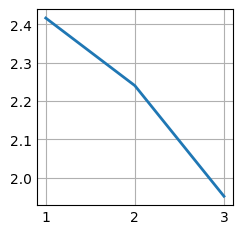

In [55]:
plt.style.use('_mpl-gallery')

# make data
x = [1,2,3]
y = stacked[:,:,0][3]

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)
ax.plot(x, stacked_untracked[:,:,0][3], linewidth=2.0)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

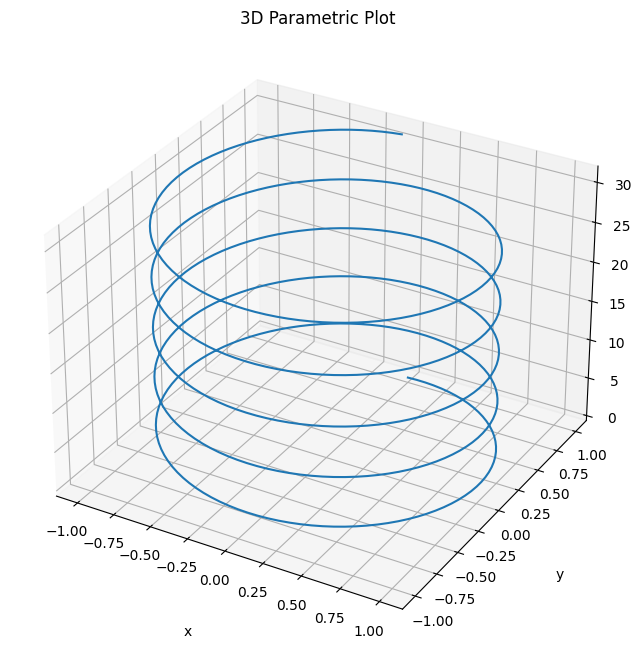

In [28]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
t = stacked[]
x = np.sin(t)
y = np.cos(t)

ax.plot3D(x, y, t)
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('t', labelpad=20)

plt.show()

In [15]:
for day, info in avg_records.items():
    print(info)
    print("n")


[[4.4707113  0.04837866 0.22254184 0.         0.        ]
 [4.33263598 0.04262552 0.37343096 0.         0.        ]
 [3.83682008 0.02641213 0.54733264 0.         0.        ]]
n
[[3.83891213 0.03945009 0.34648336 0.2109484  0.08607292]
 [3.68828452 0.04981072 0.37437737 0.07282327 0.02659892]
 [3.29288703 0.04477984 0.45651524 0.04572624 0.0167364 ]]
n
[[3.10891089 0.05033003 0.28481848 0.41980198 0.07788779]
 [2.99669967 0.05330033 0.38019802 0.20891089 0.02574257]
 [2.82838284 0.04752475 0.50231023 0.15528053 0.02706271]]
n
[[2.416      0.03466667 0.26933333 0.63733333 0.06933333]
 [2.24       0.05333333 0.42933333 0.44       0.03733333]
 [1.952      0.02133333 0.688      0.25066667 0.032     ]]
n


We now do something similar for approval games

In [71]:
def approval_target_indicators(game, verbose=False):
    wolves = game[0]['werewolves']
    villagers = game[0]['villagers']

    # this will be an object of lists with each list containing the accusation and voting stats for the day
    target_record = {}
    
    vote_rounds = []
    for i, step in enumerate(game):

        if step['phase'] == Phase.NIGHT or i == 0:
            continue
        if step["phase"] == Phase.VOTING:
            vote_rounds.append(step)
        if step['day'] not in target_record.keys():
            target_record[step['day']] = []

        villager_votes = [vote for player, vote in step['votes'].items() if player not in wolves]
        all_votes = list(step['votes'].values())

        villager_targets = [np.where(np.array(villager_vote) == -1)[0] for villager_vote in villager_votes]
        villager_likes = [np.where(np.array(villager_vote) == 1)[0] for villager_vote in villager_votes]
        villager_neutrals = [np.where(np.array(villager_vote) == 0)[0] for villager_vote in villager_votes]

        v_target_counter = Counter(np.concatenate(villager_targets))
        v_like_counter = Counter(np.concatenate(villager_likes))
        v_neutral_counter = Counter(np.concatenate(villager_neutrals))

        ## AVERAGE UNIQUE TARGETS, LIKES, NEUTRALS ## 
        v_avg_target_count = np.mean([len(targets) for targets in villager_targets])
        v_avg_like_count = np.mean([len(targets) for targets in villager_likes])
        v_avg_neutral_count = np.mean([len(targets) for targets in villager_neutrals])

        # do villagers target themselves and or like themselves
        avg_vself_target = sum([1 for k,v in step['votes'].items() if v[int(k.split("_")[-1])] == -1 and k not in wolves]) / float(len(villager_votes))
        avg_vself_like = sum([1 for k,v in step['votes'].items() if v[int(k.split("_")[-1])] == 1 and k not in wolves]) / float(len(villager_votes))

        most_common_n_targets = int(len(v_target_counter)*0.3)
        most_common_n_likes = int(len(v_like_counter)*0.3)

        wolves_in_most_common_targets =\
            [int(wolf.split("_")[-1]) for wolf in wolves if int(wolf.split("_")[-1]) in [idx for idx, _ in v_target_counter.most_common(max(1,most_common_n_targets))]]

        wolves_in_most_common_likes =\
            [int(wolf.split("_")[-1]) for wolf in wolves if int(wolf.split("_")[-1]) in [idx for idx, _ in v_like_counter.most_common(max(1,most_common_n_likes))]]

        if step["phase"] == Phase.VOTING:
            if len(vote_rounds) == 1:
                dead_players = []
                dead_wolves = []
                dead_villagers = []
            else:
                dead_players = list((set(step['executed']) & set(vote_rounds[-2]['executed'])) | set(step['killed']))
                dead_wolves = list(set(wolves) & set(dead_players))
                dead_villagers = list(set(villagers) & set(dead_players))
        else:
            dead_players = list(set(step['executed']) | set(step['killed']))
            dead_wolves = list(set(wolves) & set(dead_players))
            dead_villagers = list(set(villagers) & set(dead_players))
        
        # do the most liked individuals also get the least amount of votes?
        total_target_votes = sum(v_target_counter.values())
        total_like_votes = sum(v_like_counter.values())

        # target percentages
        percent_of_vtargets_toward_dead_players = sum([v_target_counter[int(dead_player.split("_")[-1])] for dead_player in dead_players]) / float(total_target_votes)
        percent_of_vtargets_toward_wolves = sum([v_target_counter[int(wolf.split("_")[-1])] for wolf in wolves]) / float(total_target_votes)
        percent_of_vtargets_toward_dead_wolves = sum([v_target_counter[int(dead_wolf.split("_")[-1])] for dead_wolf in dead_wolves]) / float(total_target_votes)
        percent_of_vtargets_toward_alive_wolves = sum([v_target_counter[int(wolf.split("_")[-1])] for wolf in wolves if wolf not in dead_wolves]) / float(total_target_votes)

        # how many likes are for other trusted villagers?
        percentage_of_vlikes_for_alive_villagers = sum([v_like_counter[int(villager.split("_")[-1])] for villager in villagers if villager not in dead_villagers]) / float(total_like_votes)
        percentage_of_vlikes_for_dead_villagers = sum([v_like_counter[int(dead_villager.split("_")[-1])] for dead_villager in dead_villagers]) / float(total_like_votes)

        percentage_of_vlikes_for_dead_wolves = sum([v_like_counter[int(dead_wolf.split("_")[-1])] for dead_wolf in dead_wolves]) / float(total_like_votes)
        percentage_of_vlikes_for_alive_wolves = sum([v_like_counter[int(wolf.split("_")[-1])] for wolf in wolves if wolf not in dead_wolves]) / float(total_like_votes)


        # TODO: DO I repeat the above for numbers in the top n votes?
        target_record[step['day']].append([v_avg_target_count,
                                           v_avg_like_count,
                                           v_avg_neutral_count,
                                           avg_vself_target,
                                           avg_vself_like,
                                           most_common_n_targets,
                                           len(wolves_in_most_common_targets),
                                           most_common_n_likes,
                                           len(wolves_in_most_common_likes),
                                           percent_of_vtargets_toward_dead_players,
                                           percent_of_vtargets_toward_wolves,
                                           percent_of_vtargets_toward_dead_wolves,
                                           percent_of_vtargets_toward_alive_wolves,
                                           percentage_of_vlikes_for_alive_villagers,
                                           percentage_of_vlikes_for_dead_villagers,
                                           percentage_of_vlikes_for_dead_wolves,
                                           percentage_of_vlikes_for_alive_wolves,
                                           ])
        

        if verbose:
            phase_name = "Voting Phase" if step['phase'] == Phase.VOTING else "Accusation Phase"
            print(f'Day : {step["day"]} | Phase : {step["phase"]} - {phase_name} | Round : {step["round"]}')
            print(f'\t | - avg targetted {v_avg_target_count:.2f}, liked {v_avg_like_count:.2f}, neutral {v_avg_neutral_count:.2f}, with {avg_vself_target:.2f} share of villagers targetting themselves, and {avg_vself_like:.2f} liking themselves')
            print(f'\t | -{len(wolves_in_most_common_targets)} wolves targetted in top {most_common_n_targets} votes')
            print(f'\t | -{len(wolves_in_most_common_likes)} wolves liked in top {most_common_n_likes} likes')
            print(f'\t | - % of votes towards dead players ({percent_of_vtargets_toward_dead_players:.2f}), towards dead wolves ({percent_of_vtargets_toward_dead_wolves:.2f}), towards wolves ({percent_of_vtargets_toward_wolves:.2f}), towards living wolves ({percent_of_vtargets_toward_alive_wolves:.2f})')
            print(f'\t | - % of likes towards dead wolves ({percentage_of_vlikes_for_dead_wolves:.2f}), towards alive wolves ({percentage_of_vlikes_for_alive_wolves:.2f})')
            print(f'\t | - % of likes towards dead villagers ({percentage_of_vlikes_for_dead_villagers:.2f}), towards alive villagers ({percentage_of_vlikes_for_alive_villagers:.2f})')
            print("\n")

    return target_record

In [72]:
_ = approval_target_indicators(trained_approval_villager_wins[0], verbose=True)

Day : 1 | Phase : 0 - Accusation Phase | Round : 0
	 | - avg targetted 3.75, liked 3.75, neutral 2.50, with 0.25 share of villagers targetting themselves, and 0.125 liking themselves
	 | -2 wolves targetted in top 3 votes
	 | -0 wolves liked in top 3 likes
	 | - % of votes towards dead players (0.00), towards dead wolves (0.00), towards wolves (0.30), towards living wolves (0.30)
	 | - % of likes towards dead wolves (0.00), towards alive wolves (0.13)
	 | - % of likes towards dead villagers (0.00), towards alive villagers (0.87)


Day : 1 | Phase : 0 - Accusation Phase | Round : 1
	 | - avg targetted 3.38, liked 3.50, neutral 3.12, with 0.375 share of villagers targetting themselves, and 0.375 liking themselves
	 | -1 wolves targetted in top 3 votes
	 | -0 wolves liked in top 2 likes
	 | - % of votes towards dead players (0.00), towards dead wolves (0.00), towards wolves (0.19), towards living wolves (0.19)
	 | - % of likes towards dead wolves (0.00), towards alive wolves (0.18)
	 | - 

In [73]:
game_avg_records(trained_approval_villager_wins, approval_target_indicators)

{1: array([[3.42190476, 3.2797619 , 3.29833333, 0.35666667, 0.32095238,
         2.64952381, 0.45904762, 2.61142857, 0.5847619 , 0.        ,
         0.19448546, 0.        , 0.19448546, 0.79212616, 0.        ,
         0.        , 0.20787384],
        [3.33142857, 3.28238095, 3.38619048, 0.3502381 , 0.31071429,
         2.60952381, 0.60190476, 2.57904762, 0.53714286, 0.        ,
         0.20916051, 0.        , 0.20916051, 0.80057958, 0.        ,
         0.        , 0.19942042],
        [3.19690476, 3.38238095, 3.42071429, 0.29452381, 0.34547619,
         2.45142857, 1.03238095, 2.55809524, 0.35428571, 0.        ,
         0.29445294, 0.        , 0.29445294, 0.8392938 , 0.        ,
         0.        , 0.1607062 ]]),
 2: array([[3.44163265, 3.24108844, 3.31727891, 0.37043084, 0.3046712 ,
         2.48190476, 0.47809524, 2.41142857, 0.55238095, 0.2078003 ,
         0.18770592, 0.05850358, 0.12920234, 0.64596733, 0.13925759,
         0.05483049, 0.15994458],
        [3.32884354, 3.29655

### Quantifying losing games

### Graphs


Should we give a penalty to players that target dead wolves? More than just targetting dead players in general?

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

In [21]:
labels, values = zip(*Counter([item for sublist in [villager_win[-1]["werewolves"] for villager_win in approval_trained_villager_wins] for item in sublist]).items())
indexes = np.arange(len(labels))
width = 10

# plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)
# plt.tight_layout()
# plt.xticks(rotation=60)
# plt.show()npa

In [ ]:
# load up trained agent
# load up fresh agent for comparisons

# play recurrent game_w_replays with both agents

# try to answer the questions below


# play_recurrent_game_w_replays()

## Replay visualization

Need good ways to visualize the gameplay

In [ ]:
# https://towardsdatascience.com/building-interactive-network-graphs-using-pyvis-5b8e6e25cf64

In [ ]:
def print_replay(replay):
    #[wolf for wolf in stage["werewolves"]]
    #print("Werewolves \tVillagers")
    for stage in replay:
        wolf_votes = [(f'p_{wolf.split("_")[-1]}', stage["votes"][wolf]) for wolf in stage["werewolves"] if wolf in stage["votes"]]
        villager_votes = [(f'p{villager.split("_")[-1]}', stage["votes"][villager]) for villager in stage["villagers"] if villager in stage["votes"]]
        print(f'Wolves \t : {wolf_votes} \t\t Villagers : {villager_votes}')
        #print([f'{wolf.split("_")[-1]} : {stage["votes"]["player"_{wolf.split("_")[-1]}]}]' for wolf in stage["werewolves"]])
        # for wolf in stage['werewolves']:
        #     wid = wolf.split("_")[-1]
        #     pid = f"player_{wid}"
        #     stage["votes"][pid]
        #     print(f'p_{wid} : {stage["votes"][pid]}')
        # print(stage['votes'])

print_replay(replay[4])